In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import config as cfg
import seaborn as sns
import ds_functions as ds

from sklearn.model_selection import train_test_split, StratifiedKFold, LeaveOneOut
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import sklearn.metrics as metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier

from data import hf_data, hf_data_raw, t_data, t_data_raw

In [2]:
def KFold(X, y, nfolds):
    skf = StratifiedKFold(n_splits=nfolds)

    opts=()
    accuracy = 0
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        min_impurity_decrease = [0.025, 0.01, 0.005, 0.0025, 0.001]
        max_depths = [2, 5, 10, 15, 20, 25]
        criteria = ['entropy', 'gini']
        
        for k in range(len(criteria)):
            f = criteria[k]
            for d in max_depths:
                for imp in min_impurity_decrease:
                    tree = DecisionTreeClassifier(max_depth=d, criterion=f, min_impurity_decrease=imp)
                    tree.fit(X_train, y_train)
                    prd_trn = tree.predict(X_train)
                    prd_tst = tree.predict(X_test)

                    curr_accuracy = metrics.accuracy_score(y_test, prd_tst)

                    if curr_accuracy > accuracy:
                        opts = (y_train, prd_trn, y_test, prd_tst, X_train, X_test)
                        accuracy = curr_accuracy
        
#         n_estimators = [10]
#         max_depths = [5]
#         max_features = [1]

#         for k in range(len(max_depths)):
#             d = max_depths[k]
#             values = {}
#             for f in max_features:
#                 yvalues = []
#                 for n in n_estimators:
#                     rf = RandomForestClassifier(n_estimators=n, max_depth=d, max_features=f)
#                     rf.fit(X_train, y_train)
#                     prd_trn = rf.predict(X_train)
#                     prd_tst = rf.predict(X_test)
                    
#                     curr_accuracy = metrics.accuracy_score(y_test, prd_tst)

#                     if curr_accuracy > accuracy:
#                         opts = (y_train, prd_trn, y_test, prd_tst, X_train, X_test)
#                         accuracy = curr_accuracy

    return opts

# Heart Failure Dataset

## Repeating former steps

In [3]:
hf_df_wo = hf_data_raw.copy()

# creatinine_phosphokinase, outliers above 3000
hf_df_wo = hf_df_wo[hf_df_wo["creatinine_phosphokinase"] <= 3000]

# serum_creatinine, outliers above 4
hf_df_wo = hf_df_wo[hf_df_wo["serum_creatinine"] <= 4]

# platelets, outliers above 600000
hf_df_wo = hf_df_wo[hf_df_wo["platelets"] <= 600000]

len(hf_df_wo)

283

## Feature Selection

In [4]:
# Time
hf_df_features = hf_df_wo.copy().drop(columns=['time'])

## Random Forests

<Figure size 600x450 with 0 Axes>

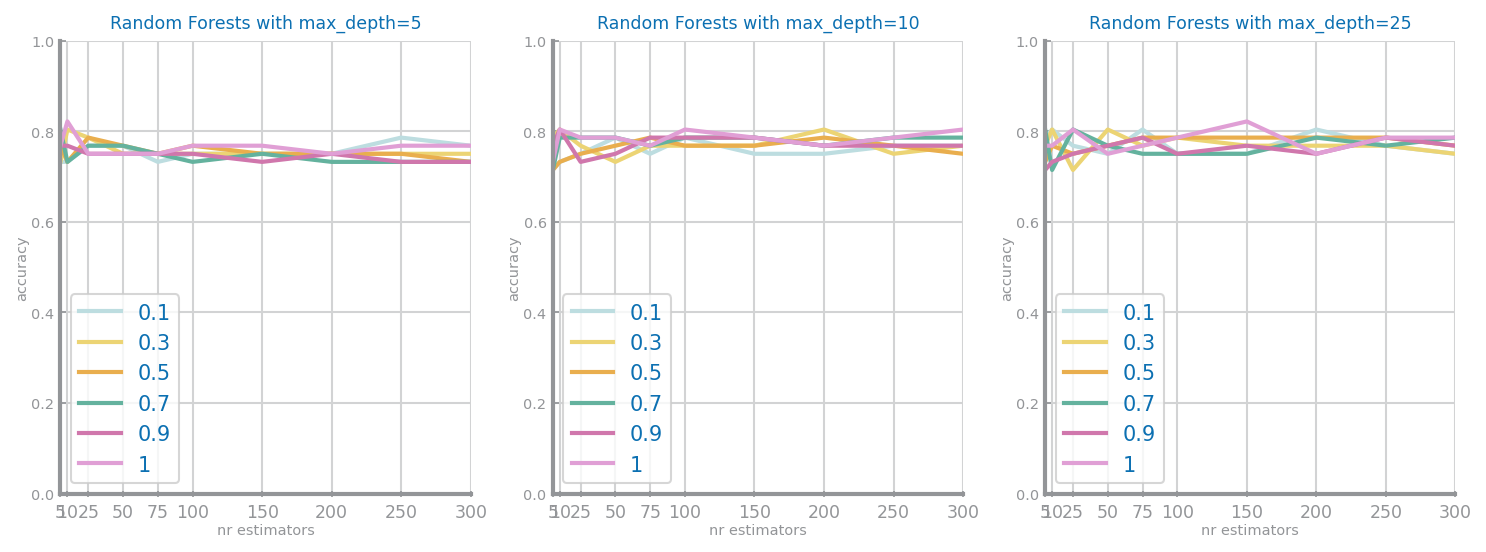

Best results with depth=5, 1.00 features and 10 estimators, with accuracy=0.8214


In [5]:
hf_df = hf_df_features.copy()

y: np.ndarray = hf_df.pop('DEATH_EVENT').values
X: np.ndarray = hf_df.values
labels = pd.unique(y)

trnY, prd_trn, tstY, prd_tst, trnX, tstX = KFold(X, y, 5)

n_estimators = [5, 10, 25, 50, 75, 100, 150, 200, 250, 300]
max_depths = [5, 10, 25]
max_features = [.1, .3, .5, .7, .9, 1]
best = ('', 0, 0)
last_best = 0
best_tree = None

cols = len(max_depths)
plt.figure()
fig, axs = plt.subplots(1, cols, figsize=(cols*ds.HEIGHT, ds.HEIGHT), squeeze=False)
for k in range(len(max_depths)):
    d = max_depths[k]
    values = {}
    for f in max_features:
        yvalues = []
        for n in n_estimators:
            rf = RandomForestClassifier(n_estimators=n, max_depth=d, max_features=f)
            rf.fit(trnX, trnY)
            prdY = rf.predict(tstX)
            yvalues.append(metrics.accuracy_score(tstY, prdY))
            if yvalues[-1] > last_best:
                best = (d, f, n)
                last_best = yvalues[-1]
                best_tree = rf

        values[f] = yvalues
    ds.multiple_line_chart(n_estimators, values, ax=axs[0, k], title='Random Forests with max_depth=%d'%d,
                           xlabel='nr estimators', ylabel='accuracy', percentage=True)

plt.show()
print('Best results with depth=%d, %1.2f features and %d estimators, with accuracy=%1.4f'%(best[0], best[1], best[2], last_best))

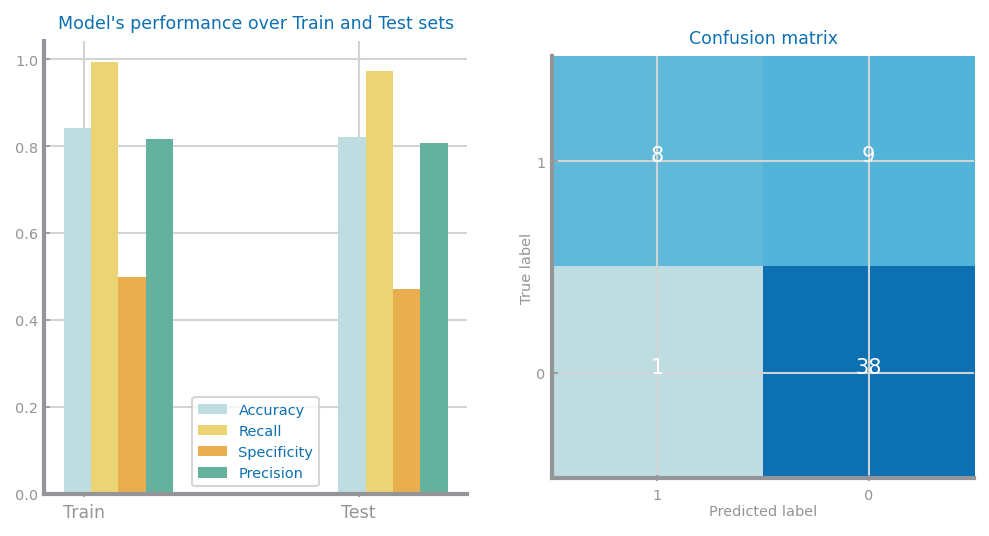

In [6]:
prd_trn = best_tree.predict(trnX)
prd_tst = best_tree.predict(tstX)
ds.plot_evaluation_results(pd.unique(y), trnY, prd_trn, tstY, prd_tst)

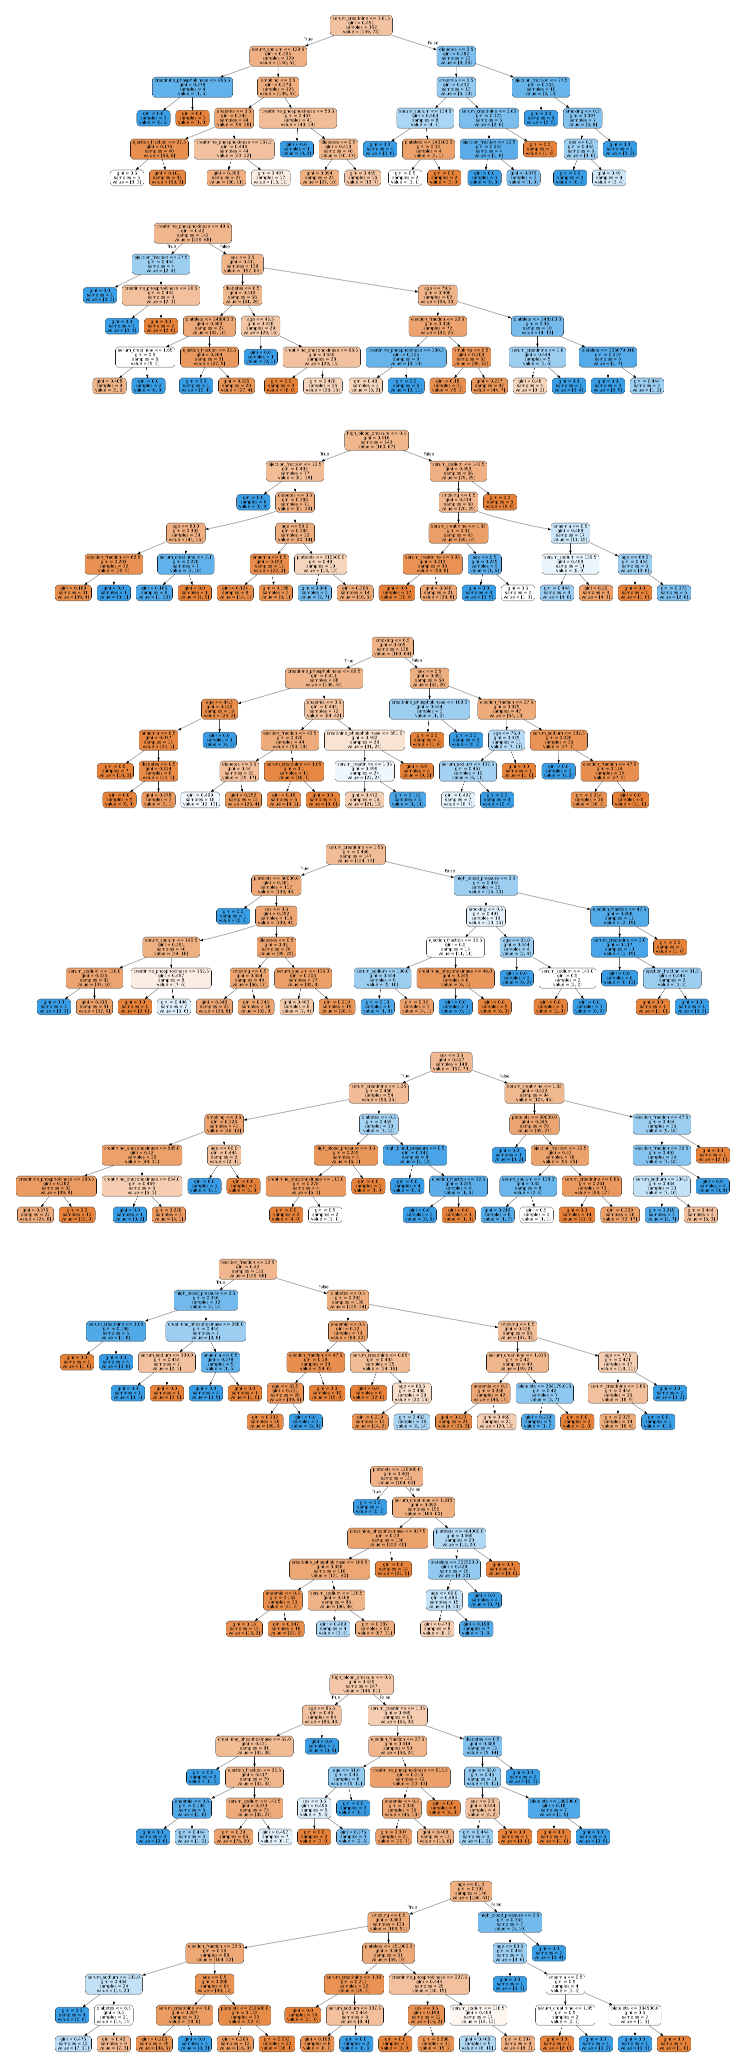

In [7]:
from sklearn.tree import export_graphviz
from subprocess import call

fig, axs = plt.subplots(len(best_tree.estimators_), 1, figsize=(16, 18), squeeze=False)
i = 0
for tree_in_forest in best_tree.estimators_:
    dot_data = export_graphviz(tree_in_forest,
                feature_names=hf_df.columns,
                filled=True,
                rounded=True,
                out_file='dtree.dot')
    # Convert to png
    call(['dot', '-Tpng', 'dtree.dot', '-o', 'dtree.png', '-Gdpi=600'])

    axs[i, 0].imshow(plt.imread('dtree.png'))
    axs[i, 0].axis('off')
    
    i += 1
plt.show()

## Bagging with KNN

In [8]:
hf_df_wo = hf_data.copy()

# creatinine_phosphokinase, outliers above 3000
hf_df_wo = hf_df_wo[hf_df_wo["creatinine_phosphokinase"] <= 3000]

# serum_creatinine, outliers above 4
hf_df_wo = hf_df_wo[hf_df_wo["serum_creatinine"] <= 4]

# platelets, outliers above 600000
hf_df_wo = hf_df_wo[hf_df_wo["platelets"] <= 600000]

# Feature selection
hf_df_features = hf_df_wo.copy().drop(columns=['time'])


df_nr = pd.DataFrame(hf_df_features, columns=hf_df_features.select_dtypes(include=['float64','int64']).columns) 
df_sb = pd.DataFrame(hf_df_features, columns=hf_df_features.select_dtypes(include=['bool']).columns)

transf = StandardScaler(with_mean=True, with_std=True, copy=True).fit(df_nr)
norm_data_zscore = pd.DataFrame(transf.transform(df_nr), columns=df_nr.columns)
norm_data_zscore = norm_data_zscore.join(df_sb, how='inner')
norm_data_zscore.describe(include='all')

,age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium,anaemia,diabetes,high_blood_pressure,smoking,DEATH_EVENT
count,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268,268,268,268,268
unique,NaN,NaN,NaN,NaN,NaN,NaN,2,2,2,2,2
top,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False
freq,NaN,NaN,NaN,NaN,NaN,NaN,149,155,169,185,181
mean,-0.007878,0.016870,0.007182,0.003723,0.008634,-0.001367,NaN,NaN,NaN,NaN,NaN
std,0.996368,1.018721,1.002497,1.014574,1.003471,1.014208,NaN,NaN,NaN,NaN,NaN
min,-1.772559,-0.800851,-2.053301,-2.737298,-1.308982,-5.348269,NaN,NaN,NaN,NaN,NaN
25%,-0.920936,-0.643066,-0.686446,-0.572568,-0.631726,-0.594341,NaN,NaN,NaN,NaN,NaN
50%,-0.069314,-0.398453,-0.003019,0.052125,-0.293099,0.084792,NaN,NaN,NaN,NaN,NaN
75%,0.718437,0.229886,0.594980,0.504529,0.214843,0.763924,NaN,NaN,NaN,NaN,NaN


<Figure size 600x450 with 0 Axes>

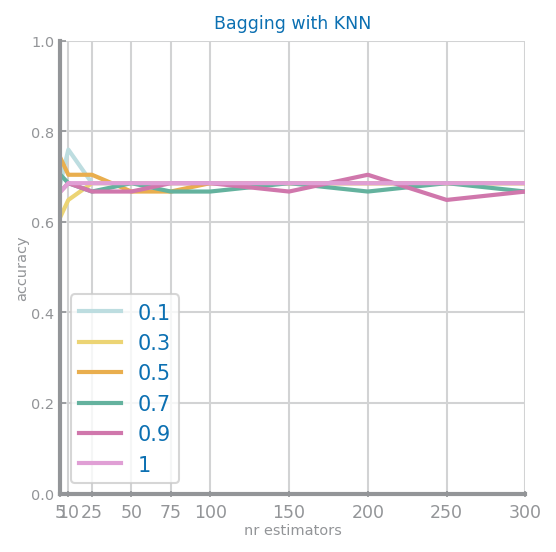

Best results with 0.10 features and 10 estimators, with accuracy=0.7593


In [9]:
hf_df = norm_data_zscore.copy()

y: np.ndarray = hf_df.pop('DEATH_EVENT').values
X: np.ndarray = hf_df.values
labels = pd.unique(y)

trnY, prd_trn, tstY, prd_tst, trnX, tstX = KFold(X, y, 5)

n_estimators = [5, 10, 25, 50, 75, 100, 150, 200, 250, 300]
max_features = [.1, .3, .5, .7, .9, 1]
best = ('', 0, 0)
last_best = 0
best_tree = None

plt.figure()
fig, axs = plt.subplots(1, 1, figsize=(ds.HEIGHT, ds.HEIGHT), squeeze=False)
values = {}
for f in max_features:
    yvalues = []
    for n in n_estimators:
        bg = BaggingClassifier(base_estimator=KNeighborsClassifier(n_neighbors=5, metric='chebyshev'), n_estimators=n, max_features=f)
        bg.fit(trnX, trnY)
        prdY = bg.predict(tstX)
        yvalues.append(metrics.accuracy_score(tstY, prdY))
        if yvalues[-1] > last_best:
            best = (f, n)
            last_best = yvalues[-1]
            best_tree = bg

    values[f] = yvalues
ds.multiple_line_chart(n_estimators, values, ax=axs[0, 0], title='Bagging with KNN',
                       xlabel='nr estimators', ylabel='accuracy', percentage=True)

plt.show()
print('Best results with %1.2f features and %d estimators, with accuracy=%1.4f'%(best[0], best[1], last_best))

# Toxicity Dataset

### Correlation

[46, 53, 78, 116, 178, 260, 288, 349, 383, 405, 408, 414, 424, 456, 465, 467, 473, 646, 656, 657, 683, 685, 758, 759, 819, 871, 960]


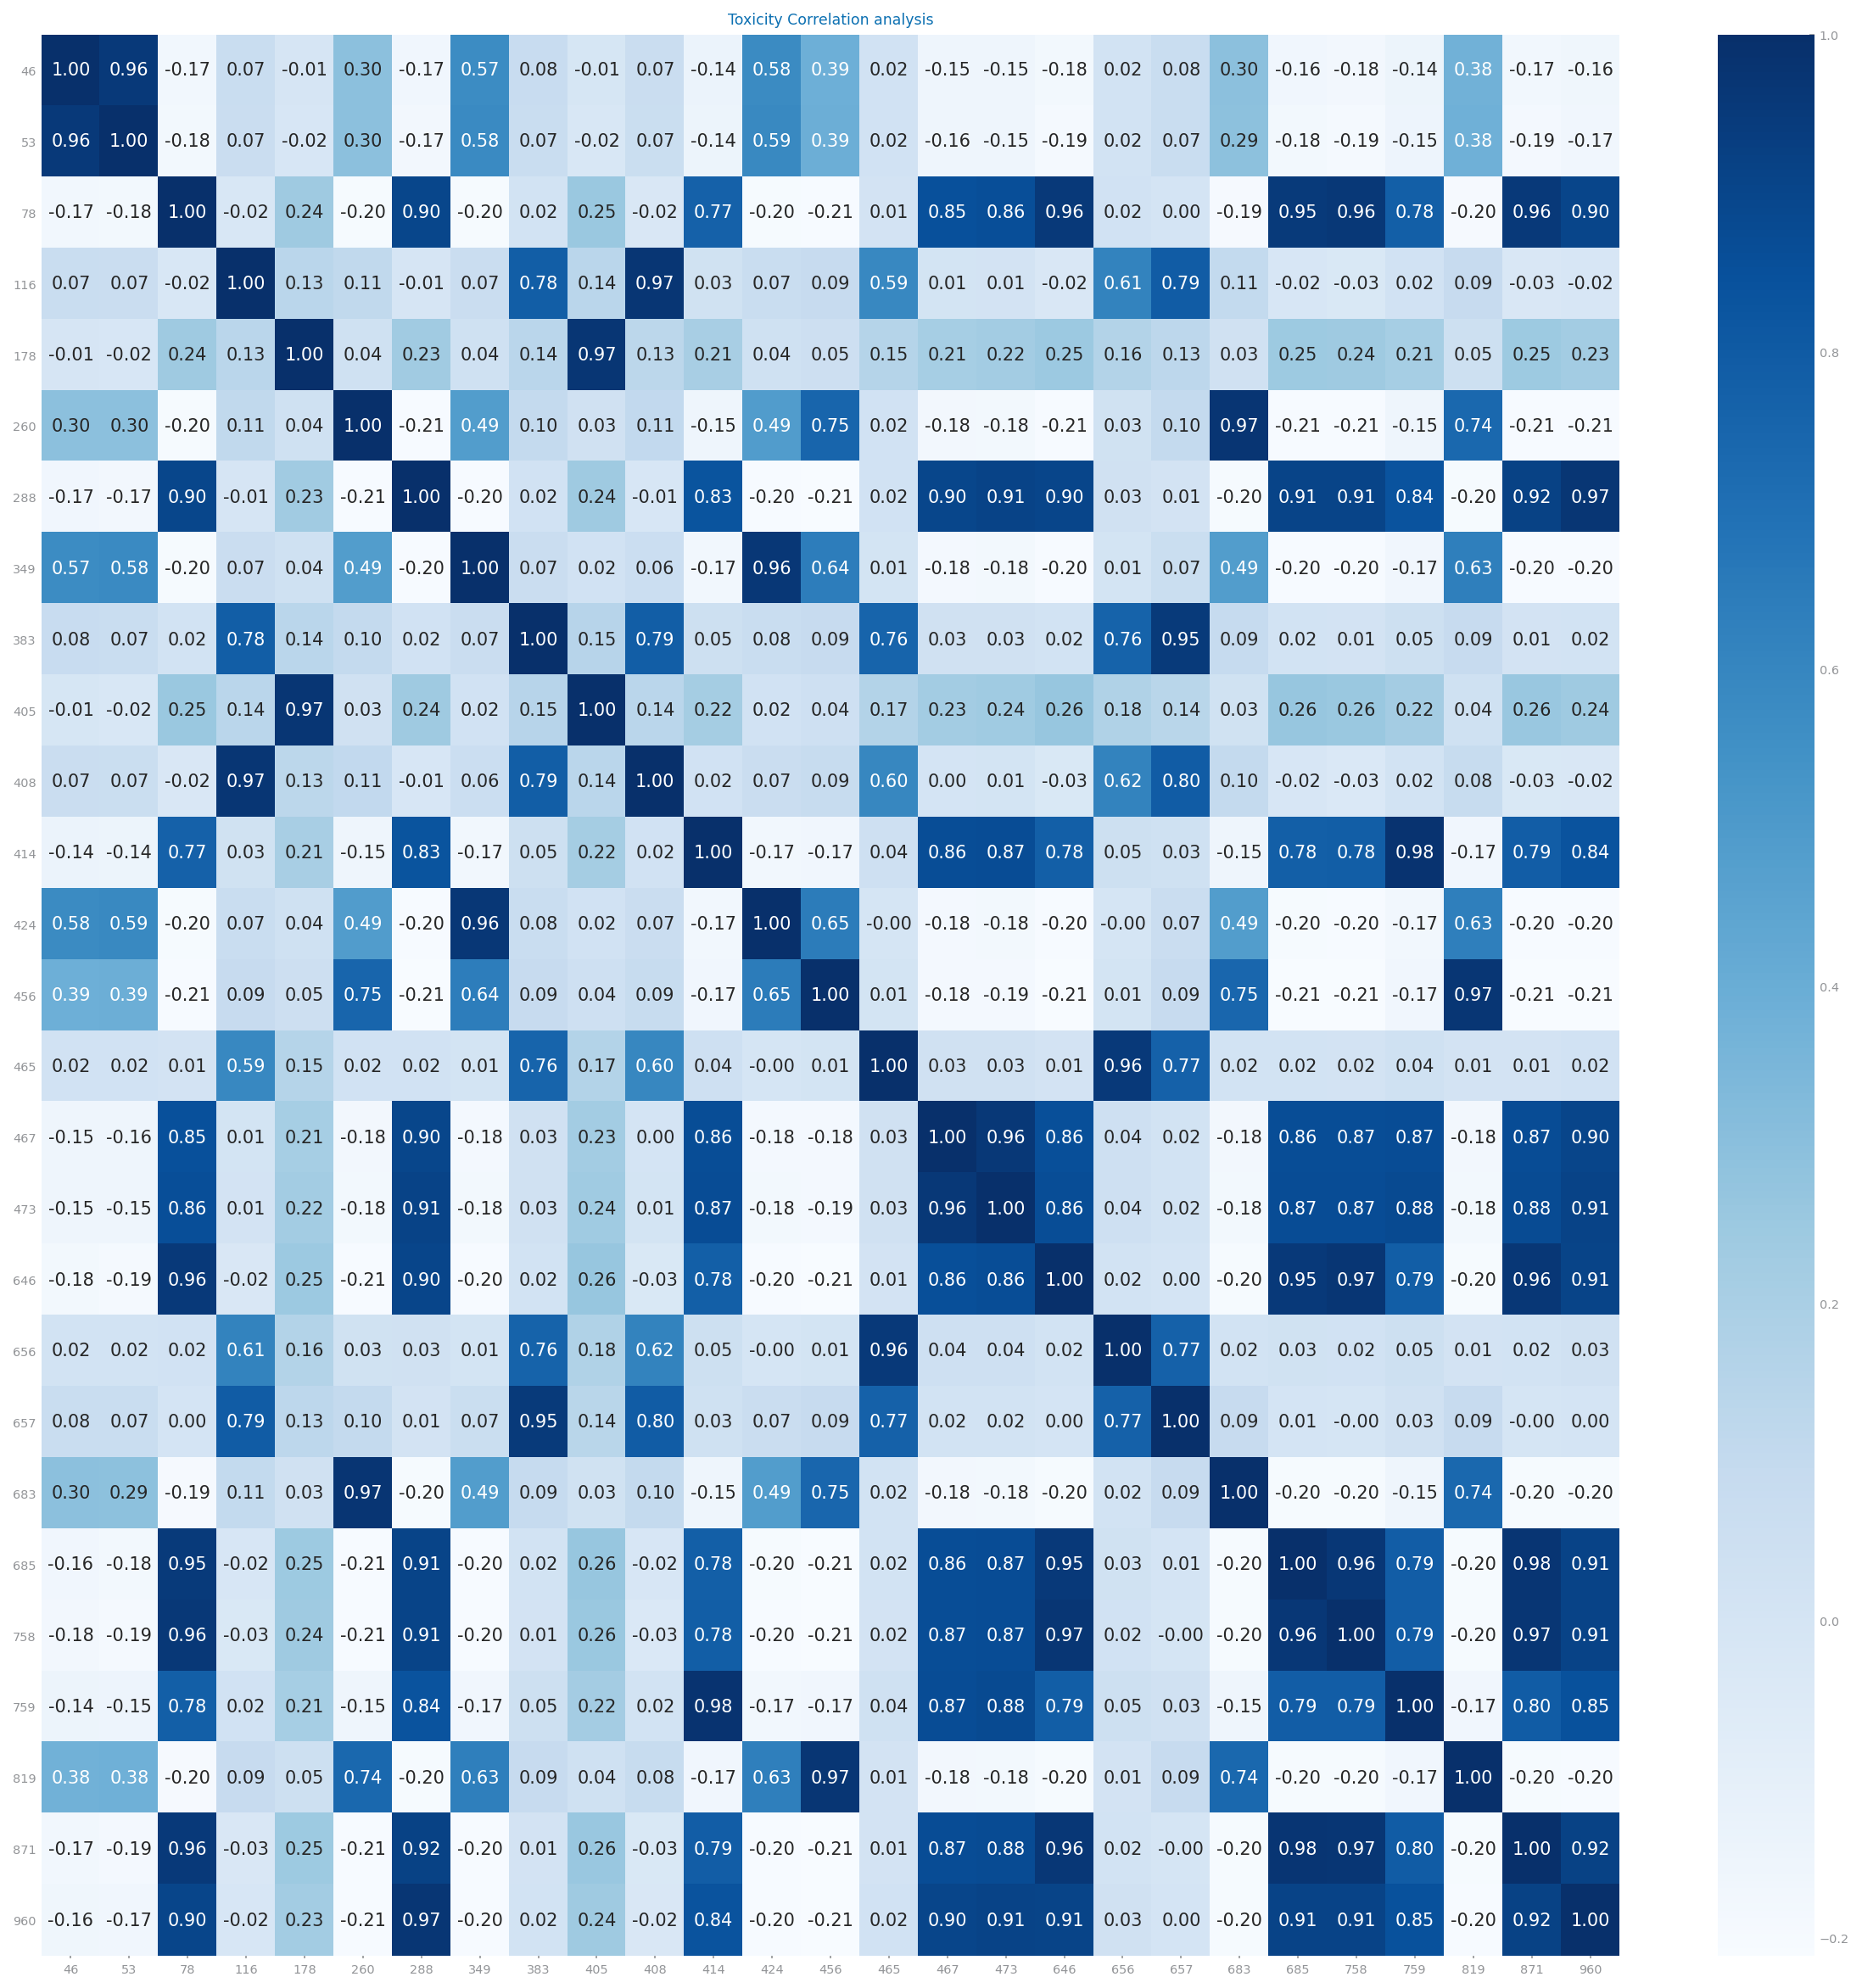

In [10]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_abs_correlations(df):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr

cp_data = t_data.copy()
most_cor = get_abs_correlations(cp_data)
most_cor = most_cor[most_cor > 0.95]

columns_tox = []
for i in range(len(most_cor.index)):
    columns_tox += [most_cor.index[i][0], most_cor.index[i][1]]
columns_tox = sorted(list(set(columns_tox)))
print(columns_tox)

corr_mtx_toxicity = t_data.corr().loc[columns_tox, columns_tox]

fig = plt.figure(figsize=(20, 20))
sns.heatmap(corr_mtx_toxicity, xticklabels=columns_tox, yticklabels=columns_tox, annot=True, cmap='Blues', fmt='.2f')
plt.yticks(rotation=0)
plt.title('Toxicity Correlation analysis')
plt.show()

## Feature Selection

In [11]:
# 685 stays
# Goes 78, 288, 467, 473, 646, 758, 871, 960 
t_df_features = t_data.copy().drop(columns=[78, 288, 467, 473, 646, 758, 871, 960])

# Stays 456, 260, 383, 465, 349, 116, 46, 178, 414
# Goes 819, 683, 657, 656, 424, 408, 53, 405, 759
t_df_features = t_df_features.drop(columns=[819, 683, 657, 656, 424, 408, 53, 405, 759])

[5, 15, 125, 168, 236, 342, 434, 732, 749, 902, 976, 995]


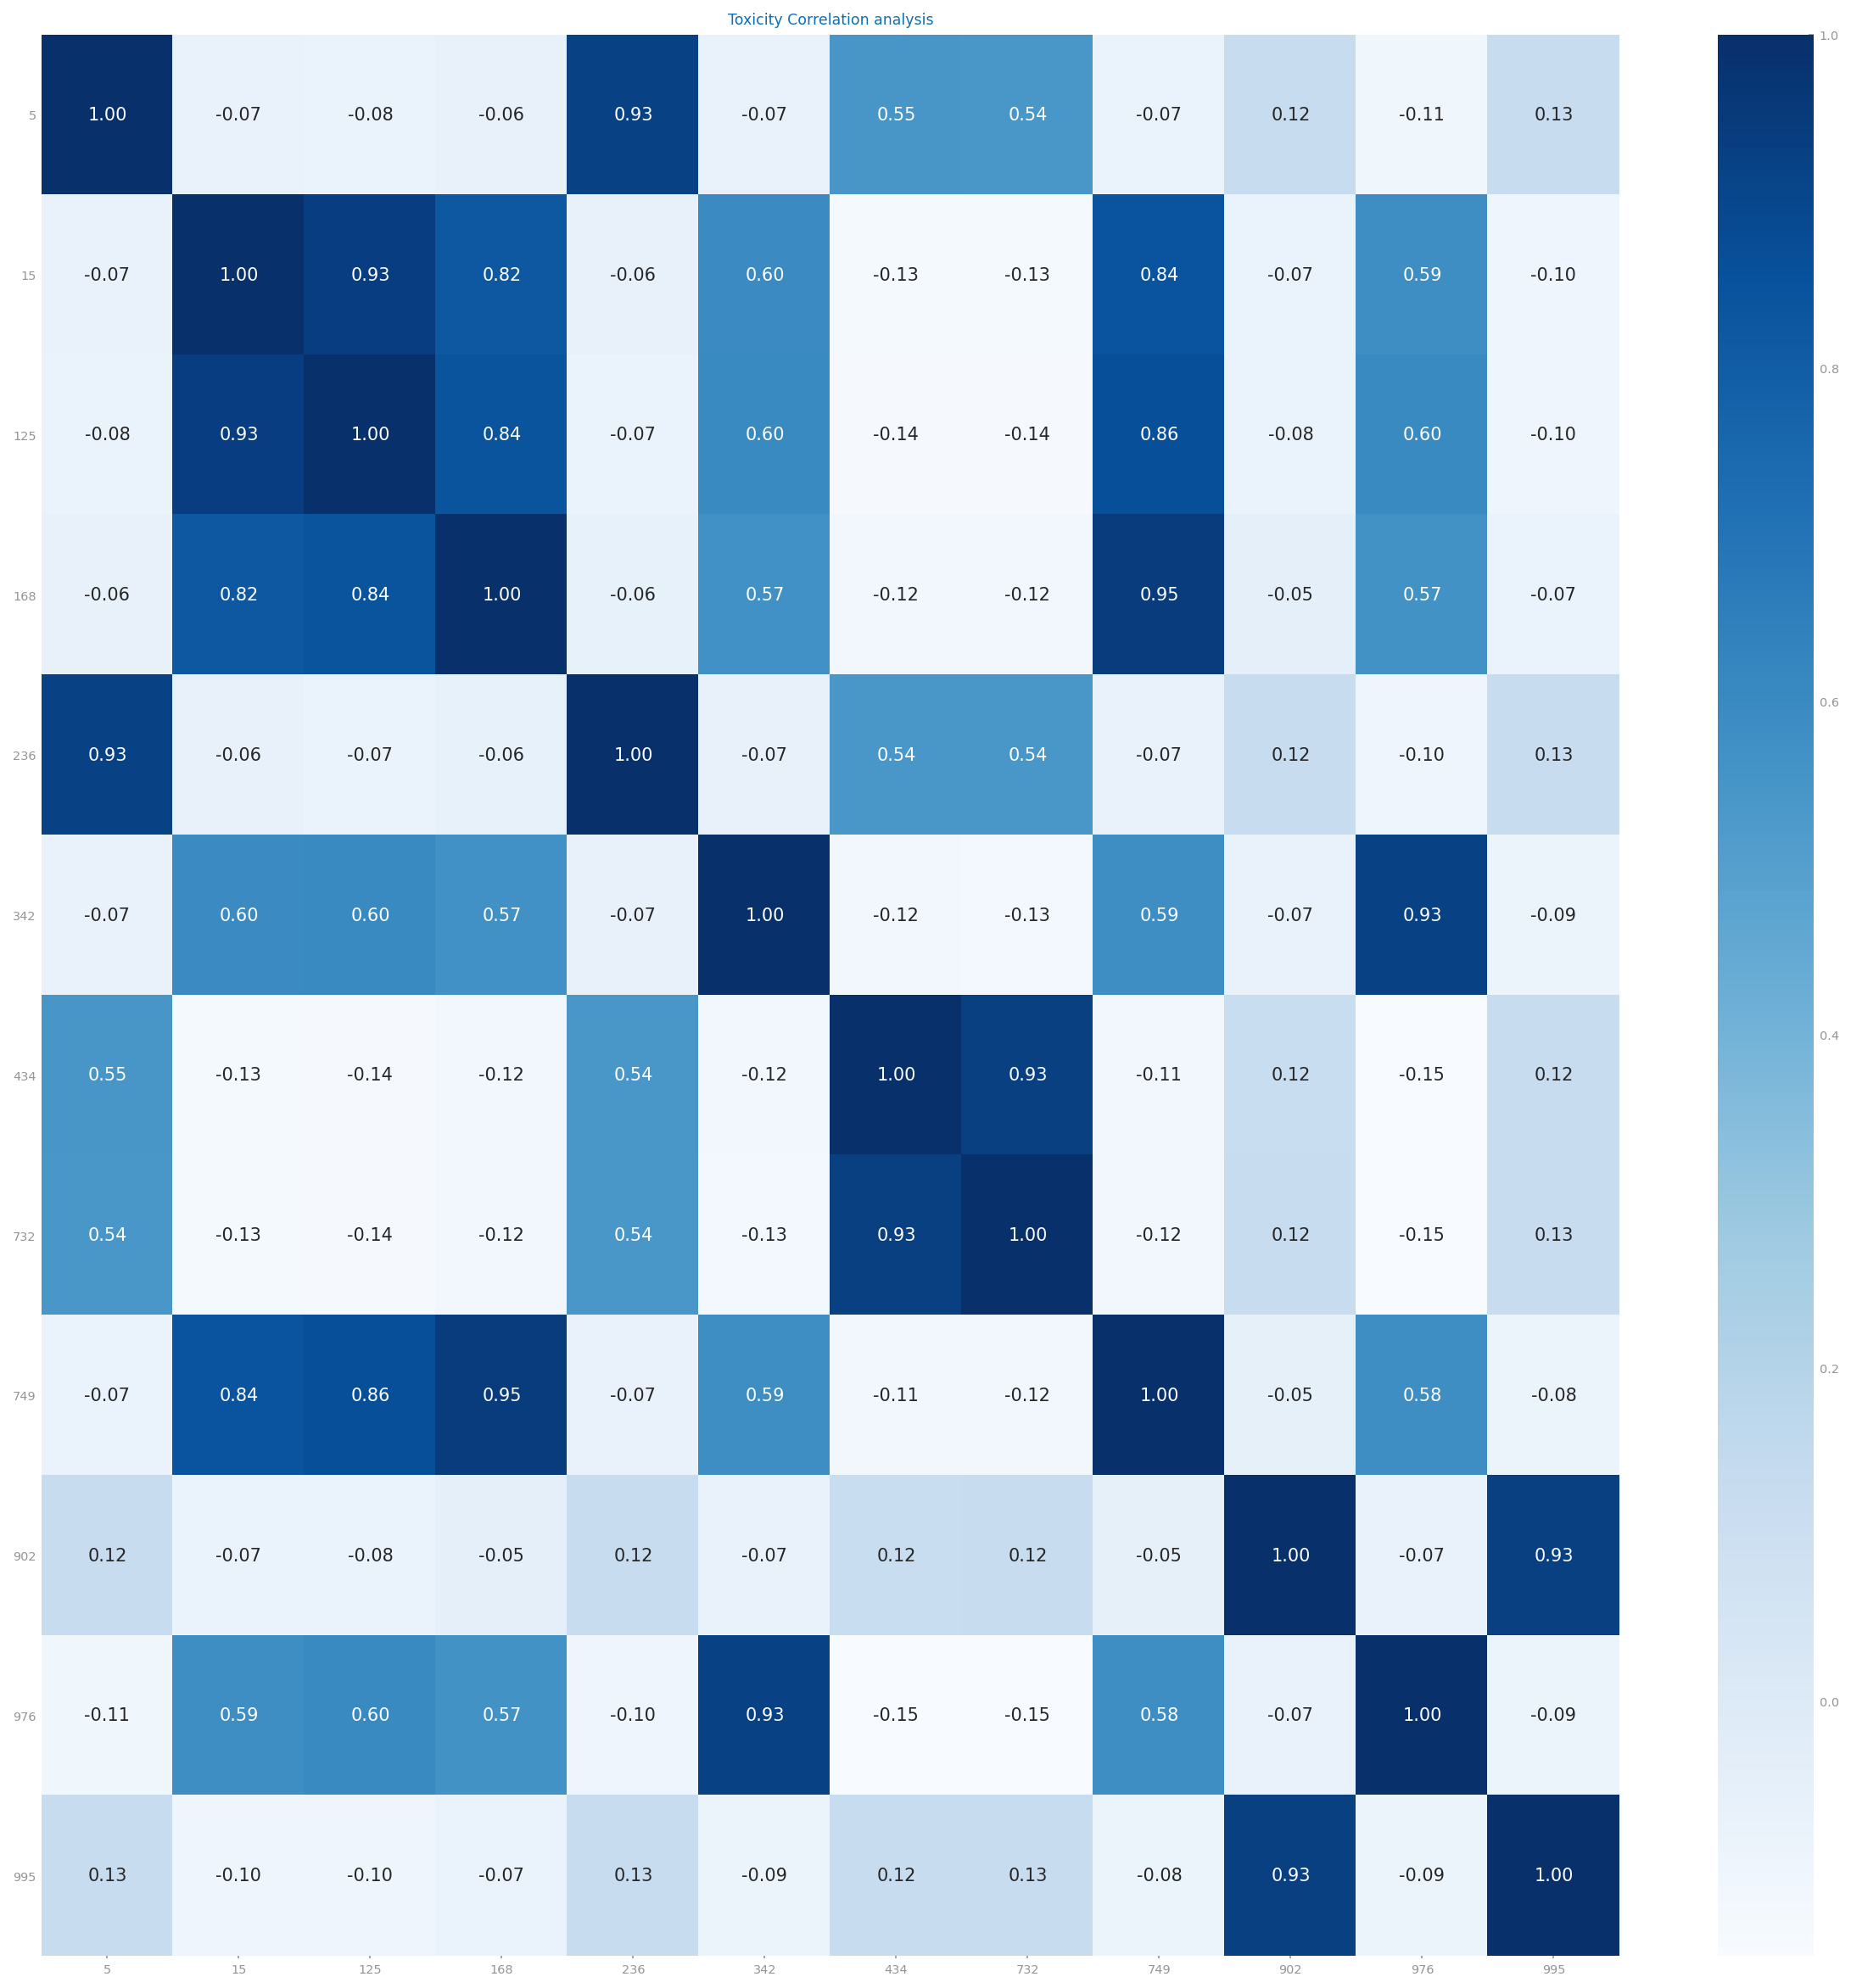

In [12]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_abs_correlations(df):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr

cp_data = t_df_features.copy()
most_cor = get_abs_correlations(cp_data)
most_cor = most_cor[most_cor > 0.925]

columns_tox = []
for i in range(len(most_cor.index)):
    columns_tox += [most_cor.index[i][0], most_cor.index[i][1]]
columns_tox = sorted(list(set(columns_tox)))
print(columns_tox)

corr_mtx_toxicity = t_data.corr().loc[columns_tox, columns_tox]

fig = plt.figure(figsize=(20, 20))
sns.heatmap(corr_mtx_toxicity, xticklabels=columns_tox, yticklabels=columns_tox, annot=True, cmap='Blues', fmt='.2f')
plt.yticks(rotation=0)
plt.title('Toxicity Correlation analysis')
plt.show()

## Random Forests

5
0.1
5
10
25
50
75
0.3
5
10
25
50
75
0.5
5
10
25
50
75
0.7
5
10
25
50
75
0.9
5
10
25
50
75
1
5
10
25
50
75
10
0.1
5
10
25
50
75
0.3
5
10
25
50
75
0.5
5
10
25
50
75
0.7
5
10
25
50
75
0.9
5
10
25
50
75
1
5
10
25
50
75
25
0.1
5
10
25
50
75
0.3
5
10
25
50
75
0.5
5
10
25
50
75
0.7
5
10
25
50
75
0.9
5
10
25
50
75
1
5
10
25
50
75


<Figure size 600x450 with 0 Axes>

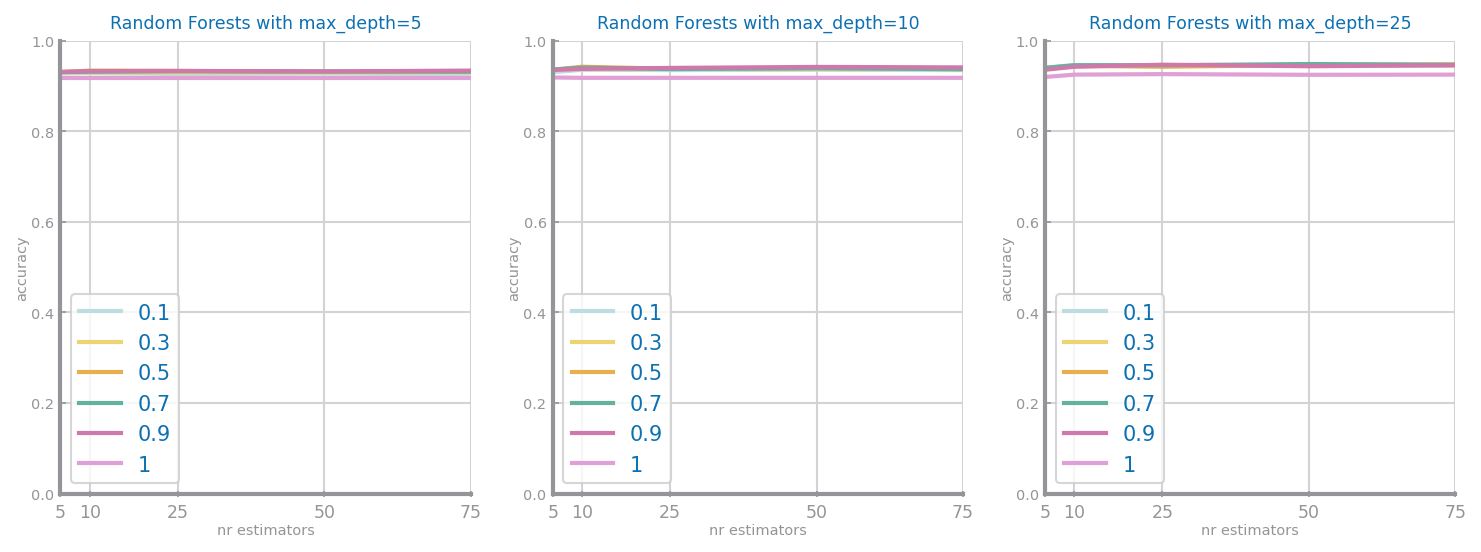

Best results with depth=25, 0.70 features and 50 estimators, with accuracy=0.9481


In [13]:
t_df = t_df_features.copy()
y: np.ndarray = t_df.pop('toxic').values
X: np.ndarray = t_df.values
labels = pd.unique(y)

trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)

n_estimators = [5, 10, 25, 50, 75]
max_depths = [5, 10, 25]
max_features = [.1, .3, .5, .7, .9, 1]
best = ('', 0, 0)
last_best = 0
best_tree = None

cols = len(max_depths)
plt.figure()
fig, axs = plt.subplots(1, cols, figsize=(cols*ds.HEIGHT, ds.HEIGHT), squeeze=False)
for k in range(len(max_depths)):
    d = max_depths[k]
    print(d)
    values = {}
    for f in max_features:
        yvalues = []
        print(f)
        for n in n_estimators:
            print(n)
            rf = RandomForestClassifier(n_estimators=n, max_depth=d, max_features=f)
            rf.fit(trnX, trnY)
            prdY = rf.predict(tstX)
            yvalues.append(metrics.accuracy_score(tstY, prdY))
            if yvalues[-1] > last_best:
                best = (d, f, n)
                last_best = yvalues[-1]
                best_tree = rf

        values[f] = yvalues
    ds.multiple_line_chart(n_estimators, values, ax=axs[0, k], title='Random Forests with max_depth=%d'%d,
                           xlabel='nr estimators', ylabel='accuracy', percentage=True)

plt.show()
print('Best results with depth=%d, %1.2f features and %d estimators, with accuracy=%1.4f'%(best[0], best[1], best[2], last_best))

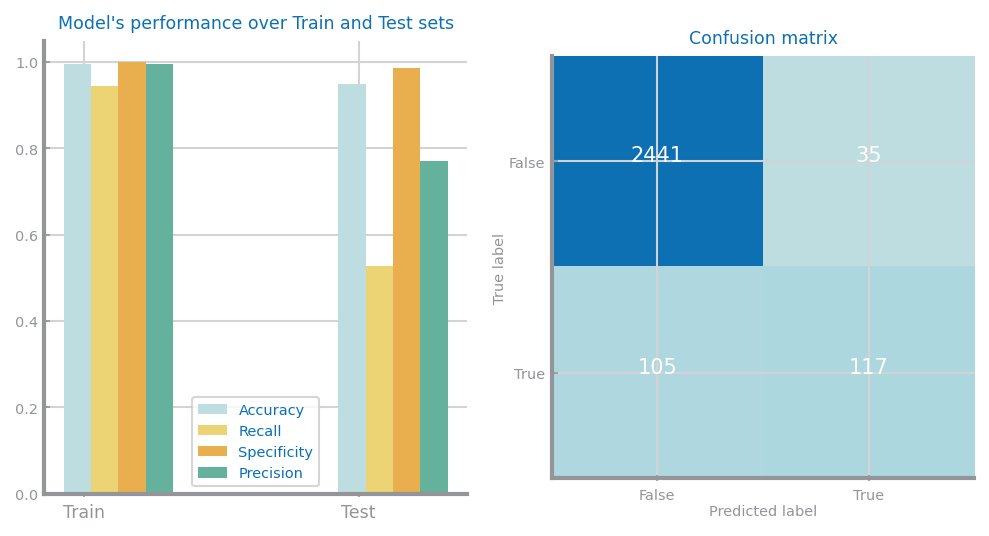

In [14]:
prd_trn = best_tree.predict(trnX)
prd_tst = best_tree.predict(tstX)
ds.plot_evaluation_results(pd.unique(y), trnY, prd_trn, tstY, prd_tst)